# Shelter Animal Outcomes 8

## Extra Trees Classifier

In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('../Shelter_train.csv')
df_test = pd.read_csv('../Shelter_test.csv')

In [3]:
x = df_train.ix[:, :-1]
y = df_train.ix[:, -1]
df_test = df_test.drop('ID', 1)

In [4]:
clf = ExtraTreesClassifier()
cross_validation.cross_val_score(clf, x, y, scoring="log_loss")

array([-2.46626606, -2.50185029, -2.53136084])

In [6]:
%timeit clf.fit(x, y)

10 loops, best of 3: 112 ms per loop


In [7]:
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(y, 2),
              scoring='log_loss')
rfecv.fit(x, y)
X_r = rfecv.transform(x)

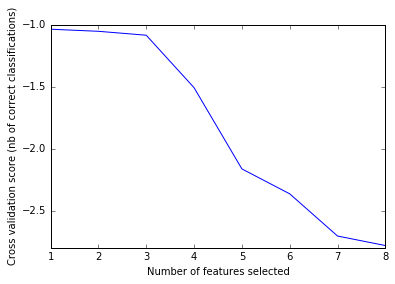

In [8]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [9]:
cross_validation.cross_val_score(clf, X_r, y, scoring="log_loss")

array([-1.04358147, -1.03719555, -1.03105202])

In [10]:
clf = rfecv.fit(x, y)
predictions = clf.predict_proba(df_test)
output = pd.DataFrame(predictions, columns=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
output.index.names = ['ID']
output.index += 1
output.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
1,0.057818,0.015950,0.114212,0.085731,0.726289
2,0.587982,0.002041,0.026304,0.198186,0.185488
3,0.534001,0.001943,0.035177,0.229778,0.199100
4,0.044823,0.022411,0.135319,0.135319,0.662128
5,0.534001,0.001943,0.035177,0.229778,0.199100


In [11]:
output.to_csv('../submission-extraTreesClassifier.2.0.csv', index_label = 'ID')